In [41]:
#importamos las clases que vamos a utilizar
import bs4 as bs
import requests
from tqdm import tqdm
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mplfinance as mpf
import plotly.express as px


In [ ]:
#guardamos en una variable la url que vamos a escrapear
resp = requests.get('https://bolsar.info/lideres.php')
resp = resp.text
soup  = bs.BeautifulSoup(resp, 'lxml')
#creamos un objeto de la clase Find para buscar todos los tags <td>
table = soup.find('table', {'class': "tabla_cierre"})

table

In [10]:
#Obtenemos los tickers del Panel Lider del MERVAL que estan en la tabla 
tickers =[]
for row in tqdm(table.findAll('tr')[1:]):
    ticker = row.findAll('td')[0].text
    tickers.append(ticker)

100%|██████████| 59/59 [00:00<00:00, 58962.10it/s]


In [11]:
#Creamos un dataframe para almacenar los tickers con el encabezado "Symbol"
#Agregamos la expresión .BA para poder descargar del yahoo finance los datos 
df = pd.DataFrame(list(zip(tickers)), 
                  columns =['Symbol'])
df = df.reset_index(drop=True)
df = df.drop_duplicates()
df ['Symbol'] = df.Symbol + '.BA'
df

,Symbol
0,ALUA.BA
3,BBAR.BA
6,BMA.BA
9,BYMA.BA
12,CEPU.BA
15,COME.BA
18,CRES.BA
21,EDN.BA
24,GGAL.BA
27,LOMA.BA


In [12]:
#Lo pasamos a una lista 
tickers_symbols = df['Symbol'].values.tolist()

In [ ]:
#Obtenemos los datos de yahoo finance y los cargamos en el dataframe "data"
#Teniendo en cuenta los tikcers del Panel General de MERVAL que obtuvimos anteriormente de la web
data = pd.DataFrame()

for t in tickers_symbols:
    tmp = yf.download(t, start='2014-02-18', end='2024-02-18', progress=False)
    tmp.reset_index(inplace=True)
    tmp['Ticker'] = t
    data = data.append(tmp, ignore_index=True)

In [10]:
#guardamos en un archivo csv el DataFrame descargado para trabajarlo de manera local
data.to_csv('data_Merval.csv', index=False)

In [17]:
data=pd.read_csv('data_Merval.csv')



In [18]:
#creamos una copia del dataframe para trabajar con el
df_precios = data.copy()

In [19]:
df_precios.shape

(46523, 8)

In [ ]:
#calcuamos el retorno intradiario con la formula propuesta
df_precios['Ret_Intradiario'] =df_precios.apply(lambda row: np.log(row.Close/row.Open), axis=1).fillna(0)

#Creamos una la columna de cierre auxiliar, desfasada para calcular el gap
df_precios['Close_Desfasado'] = df_precios['Close'].shift(1)


#Calculamos el retono de los gaps
df_precios['Ret_Gaps'] = np.log(df_precios['Open']/df_precios['Close_Desfasado']).fillna(0)

#cuando llege al ultimo ticker que lo ponga en cero
for i in range(0,df_precios.shape[0]-1):
    if df_precios.loc[i,'Ticker']!= df_precios.loc[i+1,'Ticker']:
            df_precios['Ret_Gaps'][i+1] = 0

#Eliminamos la columna auxiliar close_desfasado
df_precios.drop(columns=['Close_Desfasado'], inplace=True)

#Calculamos las variaciones 
df_precios['Variacion'] = df_precios['Adj Close'].pct_change()

#Calculamos la volatilidad

#volatilidad = activos.variaciones.rolling(250).std()100(250)**0.5 (en este caso se puede utilizar el indice VIX)
df_precios['Volatilidad'] = df_precios['Variacion'].rolling(250).std()*100**0.5

#ponemos en 0 los valores NaN en la columna Volatilidad para que no sean considerados en el analisis
df_precios['Volatilidad'].fillna(0, inplace=True)

#ponemos en 0 los valores NaN en la columna Variacion para que no sean considerados en el analisis
df_precios['Variacion'].fillna(0, inplace=True)

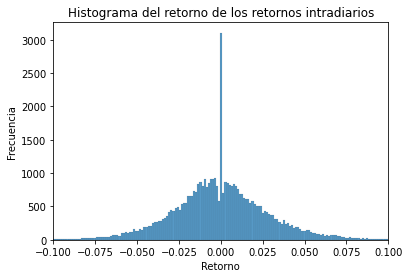

In [39]:
#graficamos el histograma del retorno de los retornos intradiarios
fig = plt.figure()
ax = plt.axes()
sns.histplot(df_precios["Ret_Intradiario"], bins=500)
plt.xlim(-0.1, 0.1)
plt.title('Histograma del retorno de los retornos intradiarios')
plt.xlabel('Retorno')
plt.ylabel('Frecuencia')
plt.show()

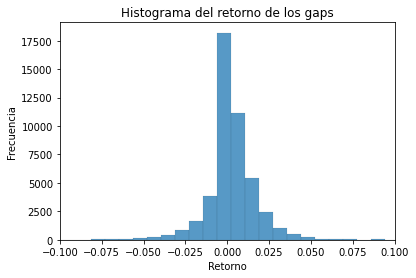

In [38]:
#graficamos el histograma del retorno de los gaps
fig = plt.figure()
ax = plt.axes()
sns.histplot(df_precios["Ret_Gaps"], bins=500)
plt.xlim(-0.1, 0.1)
plt.title('Histograma del retorno de los gaps')
plt.xlabel('Retorno')
plt.ylabel('Frecuencia')
plt.show()


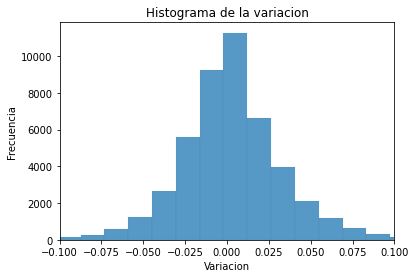

In [37]:
#graficamos el histograma de la variacion
fig = plt.figure()
ax = plt.axes()
sns.histplot(df_precios["Variacion"], bins=800)
plt.xlim(-0.1, 0.1)
plt.title('Histograma de la variacion')
plt.xlabel('Variacion')
plt.ylabel('Frecuencia')
plt.show()


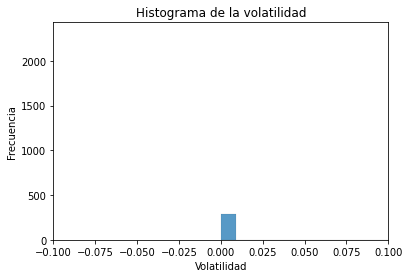

In [36]:
#graficamos el histograma de la volatilidad
fig = plt.figure()
ax = plt.axes()
sns.histplot(df_precios["Volatilidad"], bins=500)
plt.xlim(-0.1, 0.1)
plt.title('Histograma de la volatilidad')
plt.xlabel('Volatilidad')
plt.ylabel('Frecuencia')
plt.show()

### Cual es el mejor día para invertir teniendo en cuenta el retorno de los movimiento gap

In [33]:
#seteamos la fecha
df_precios['Date'] = pd.to_datetime(df_precios['Date'])

#se crea una columna para indicar los dias de la semana 
df_precios['Dia_Semana'] = df_precios['Date'].dt.dayofweek

#cargamos los dias de la semana en un diccionario
dias_semana = {'Lunes':0,'Martes':1 ,'Miercoles':2 ,'Jueves': 3, 'Viernes': 4}

#calculamos la media de los retornos agrupando los dias de la semana en un dataframe nuevo para poder graficar
df_Ret_Gap = df_precios.groupby(['Dia_Semana'])['Ret_Gaps'].mean().reset_index()

#seteamos los dias de la semana
df_Ret_Gap['Dia_Semana'] = dias_semana


In [34]:
df_Ret_Gap

,Dia_Semana,Ret_Gaps
0,Lunes,0.001992
1,Martes,0.002972
2,Miercoles,0.002627
3,Jueves,0.002577
4,Viernes,0.003403


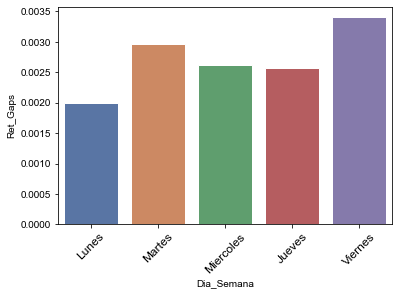

In [26]:
#grafico de los retorno de los movimientos gap en los dias de la semana
plt.xticks(fontsize=12, rotation=45)
sns.set(rc={'figure.figsize':(10,10)})
sns.barplot(x='Dia_Semana', y='Ret_Gaps', data=df_Ret_Gap)
plt.show()


#### El mejor dia para invertir teniendo en cuenta el retono gap es el dia lunes o jueves

### Cual es el mejor día para invertir teniendo en cuenta el retorno de los movimientos intradiarios

In [27]:
#calculamos el retorno intradiario agrupado por dias de la semana
df_Ret_Intra = df_precios.groupby('Dia_Semana')['Ret_Intradiario'].mean().reset_index()

#Agregamos una columna de los dias de la semana
df_Ret_Intra['Dia_Semana'] = dias_semana

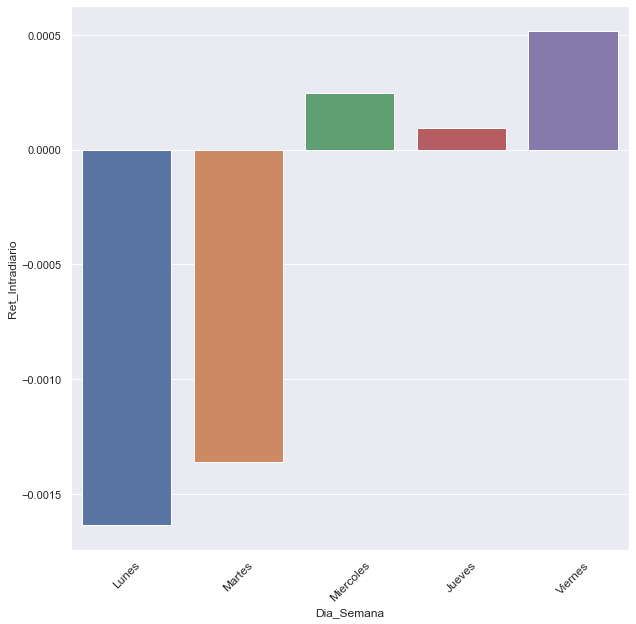

In [28]:
#grafico de los retorno de los movimientos intradiarios en los dias de la semana
plt.xticks(fontsize=12, rotation=45)
sns.set(rc={'figure.figsize':(10,10)})
sns.barplot(x='Dia_Semana', y='Ret_Intradiario', data=df_Ret_Intra)
plt.show()

#### CONCLUSION: El mejor dia para invertir en intradiario es el dia viernes(Comprar y vender ese mismo dia)

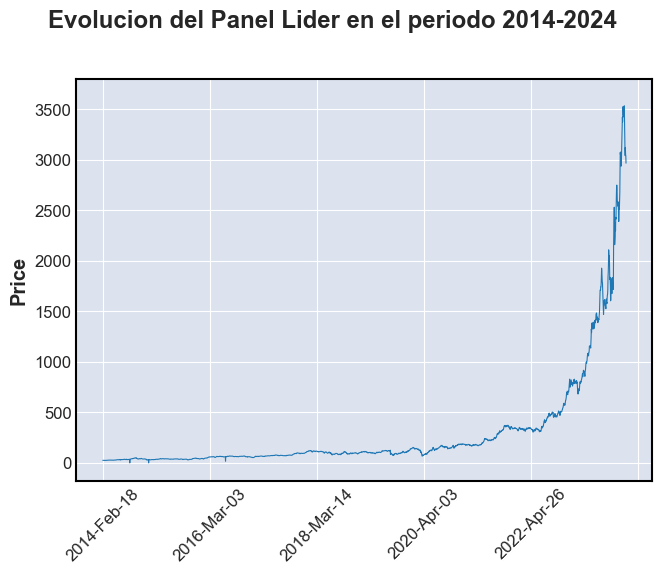

In [31]:
datap2 = df_precios.groupby("Date").agg({ 'Open':'mean', 'High':'mean', 'Low':'mean', 'Close':'mean', 'Adj Close':'mean','Ret_Intradiario':'mean', 'Ret_Gaps':'mean'})
mpf.plot(datap2, type='line', title='Evolucion del Panel Lider en el periodo 2014-2024')
plt.show()

### Cuales son las mejores acciones del panel general en las cuales se puede invertir
#### Teniendo en cuenta los Ajustes de Cierre

In [32]:
#Creo un dataframe con los datos del ultimo año
datap = df_precios[df_precios['Date'] > '2023-01-01']

#Agrupo por empresa
datap_precio= datap.groupby('Ticker').agg({'Date':'mean','Open':'mean', 'High':'mean', 'Low':'mean', 'Close':'mean', 'Adj Close':'mean','Ret_Intradiario':'mean', 'Ret_Gaps':'mean', 'Volatilidad':'mean'})

In [41]:
#Graficamos la evolucion de los precios de las acciones en
fig = px.line(datap, x='Date', y='Close', title='Evolucion del Precio de acciones en el periodo 2023-2024', color='Ticker', color_discrete_sequence=px.colors.qualitative.Dark24)

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.show()

In [37]:
#Lasordeno por el retorno intradiario y obtengo las 9 primeras 
df_precios.head().sort_values('Ret_Intradiario', ascending=False)

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,Ret_Intradiario,Ret_Gaps,Variacion,Volatilidad,Dia_Semana
0,2014-02-18,3.901785,3.964285,3.883928,3.919642,2.946759,702024.0,ALUA.BA,0.004566,0.000000,0.000000,0.0,1
4,2014-02-24,3.758928,3.794642,3.714285,3.758928,2.825935,718658.0,ALUA.BA,0.000000,0.002378,0.002381,0.0,0
1,2014-02-19,3.883928,3.901785,3.821428,3.866071,2.906484,562963.0,ALUA.BA,-0.004608,-0.009153,-0.013667,0.0,2
3,2014-02-21,3.794642,3.821428,3.705357,3.750000,2.819223,949383.0,ALUA.BA,-0.011834,0.002356,-0.009434,0.0,4
2,2014-02-20,3.901785,3.901785,3.758928,3.785714,2.846072,533178.0,ALUA.BA,-0.030200,0.009195,-0.020785,0.0,3


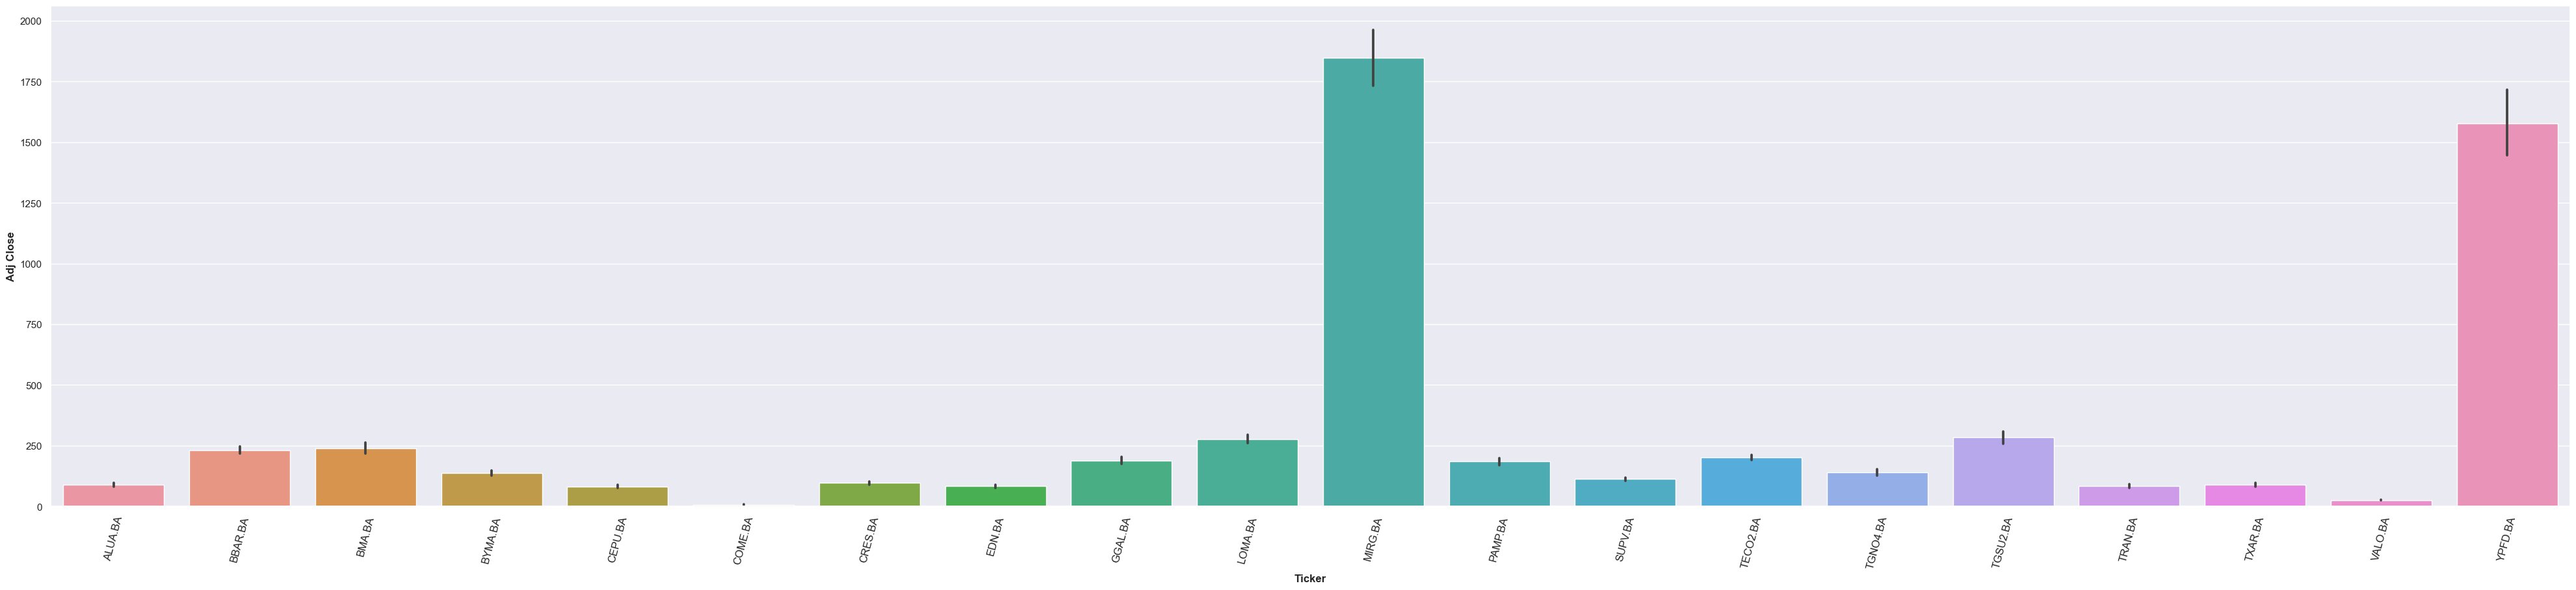

In [40]:
#Grafico las industrias con mejor retorno intradiario
plt.xticks(fontsize=12,rotation=75)
sns.set(rc={'figure.figsize':(50,10)})
sns.barplot(data= df_precios, x = 'Ticker', y = "Adj Close" )
plt.show()

#### CONCLUSION: Las mejores acciones para invertir, teniendo en cuenta el retorno intradiario son: "Mirgor", seguida por "YPF".

## Cuales fueron los momentos de alta volatilidad que afectaron al Panel Lider

In [45]:
#Agrupo por dias la media de los precios
df = df_precios.groupby("Date").agg({ 'Open':'mean', 'High':'mean', 'Low':'mean', 'Close':'mean', 'Adj Close':'mean','Ret_Intradiario':'mean', 'Ret_Gaps':'mean'})

#Creo el indice 
df.reset_index(inplace=True)


fig = px.line(df, x='Date', y='Ret_Intradiario', title='Movimiento de las acciones del Panel Lider (2014-2024)')

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
        
    )
        
)
fig.add_hline(y=0.0658, line_dash="solid", line_color="green",
                annotation_text="Maximo de la variacion", 
                annotation_position="bottom right")

fig.add_hline(y=-0.09204, line_dash="solid", line_color="red",
                annotation_text="Minimo de la variacion", 
                annotation_position="bottom right")

fig.add_hline(y=0.0208099, line_dash="dot", line_color="grey",
                annotation_text="Variacion media", 
                annotation_position="bottom left")

fig.add_hline(y=-0.02728649, line_dash="dot", line_color="grey",
                annotation_text="Variacion media", 
                annotation_position="bottom left")

'''fig.add_vrect(x0="2008-04-24", x1="2009-07-18", 
                annotation_text="Volatilidad", annotation_position="top left",
                fillcolor="green", opacity=0.30, line_width=0)'''

fig.show()

In [26]:
#Agrupo por dias la media de los precios
df = df_precios.groupby("Date").agg({ 'Open':'mean', 'High':'mean', 
                                    'Low':'mean', 'Close':'mean', 'Adj Close':'mean',
                                    'Ret_Intradiario':'mean', 'Ret_Gaps':'mean'})

#Creo el indice 
df.reset_index(inplace=True)


fig = px.line(df, x='Date', y='Adj Close', title='Movimiento del Panel Lider - Merval (2014-2024)')

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
        
    )
        
)

'''fig.add_vrect(x0="2008-04-24", x1="2009-07-18", 
                annotation_text="Volatilidad", annotation_position="top left",
                fillcolor="green", opacity=0.30, line_width=0)'''

fig.show()

### Cuales son las 9 mejores empresas para invertir teniendo en cuenta el periodo (2014-2024)

In [49]:
#Las ordeno por el retorno intradiario y obtengo las 9 primeras 
df_precios.head().sort_values('Ret_Intradiario', ascending=False)

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,Ret_Intradiario,Ret_Gaps,Variacion,Volatilidad,Dia_Semana
0,2014-02-18,3.901785,3.964285,3.883928,3.919642,2.946759,702024.0,ALUA.BA,0.004566,0.000000,0.000000,0.0,1
4,2014-02-24,3.758928,3.794642,3.714285,3.758928,2.825935,718658.0,ALUA.BA,0.000000,0.002378,0.002381,0.0,0
1,2014-02-19,3.883928,3.901785,3.821428,3.866071,2.906484,562963.0,ALUA.BA,-0.004608,-0.009153,-0.013667,0.0,2
3,2014-02-21,3.794642,3.821428,3.705357,3.750000,2.819223,949383.0,ALUA.BA,-0.011834,0.002356,-0.009434,0.0,4
2,2014-02-20,3.901785,3.901785,3.758928,3.785714,2.846072,533178.0,ALUA.BA,-0.030200,0.009195,-0.020785,0.0,3


In [50]:
#creo el dataframe agrupando los tickers
df_mejores = df_precios.groupby("Ticker").agg({ 'Open':'mean', 'High':'mean', 'Low':'mean', 'Close':'mean', 'Adj Close':'mean','Ret_Intradiario':'mean', 'Ret_Gaps':'mean', 'Variacion':'mean'})

#ordeno el dataframe por retorno de intradiario
df_mejores.sort_values('Ret_Intradiario', ascending=False, inplace=True)

#obtengo las primeras 9 empresas teniendo en cuenta el retorno de intradiario
df_mejores=df_mejores.head(9).reset_index()



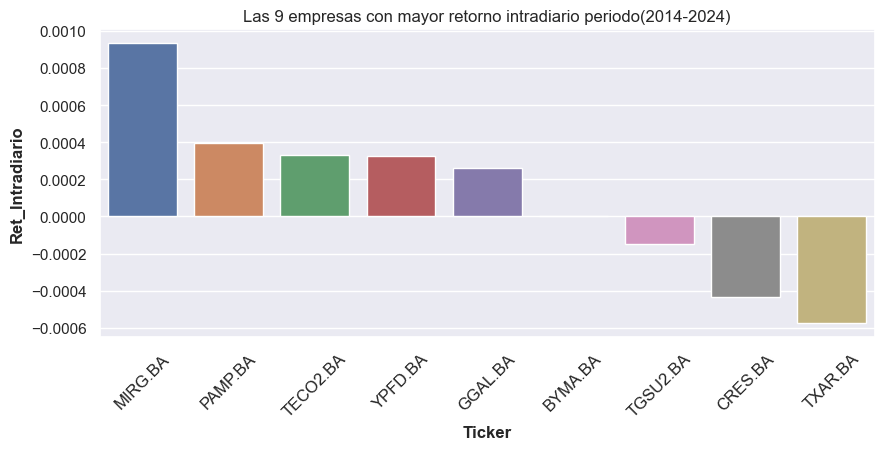

In [52]:
#Grafico de barras con las empresas que tienen el mayor retorno de intradiario
sns.set(rc={'figure.figsize':(10,4)})
plt.xticks(fontsize=12,rotation=45)
sns.barplot(data = df_mejores, x='Ticker', y='Ret_Intradiario').set(title="Las 9 empresas con mayor retorno intradiario periodo(2014-2024)")
plt.show()

##### En el grafico se muestra las empresas que tuvieron un mejor retorno a lo largo de los ultimos 10 años, la principal diferenciandose de las demas es la empresa MIRGOR seguida por la empresaa PAMPA ENERGIA.

## Calculo de las 9 empresas para invertir teniendo en cuenta la variacion de precios del ultimo año

In [44]:
#hago una copia para no modificar el dataframe original
df_top = df_precios.copy()

#creo un DF con toda la informacion del ultimo año
df_anual = df_top[df_top['Date']>= '2023-01-01 00:00:00'] 


#obtengo el df con el valor minimo de la fecha de inicio del DF
df_min = df_anual[df_anual["Date"] == df_anual["Date"].min()]

#obtengo el df con el valor maximo de la fecha de inicio del DF
df_max = df_anual[df_anual["Date"] == df_anual["Date"].max()]

#hago un merge para calcular las variaciones
df_anual_var = pd.merge(df_min, df_max, on=['Ticker'])

#calculo la variacion porcentual del ticker en el DF
df_anual_var["Variacion_%"] = (df_anual_var["Adj Close_x"] - df_anual_var["Adj Close_y"]) / df_anual_var["Adj Close_x"] * 100

#ordenamos el df
df_anual_var.sort_values('Variacion_%', ascending=False, inplace=True)

#cargamos el dF con los 10 mejores tickers
df_anual_var=df_anual_var.head(9)

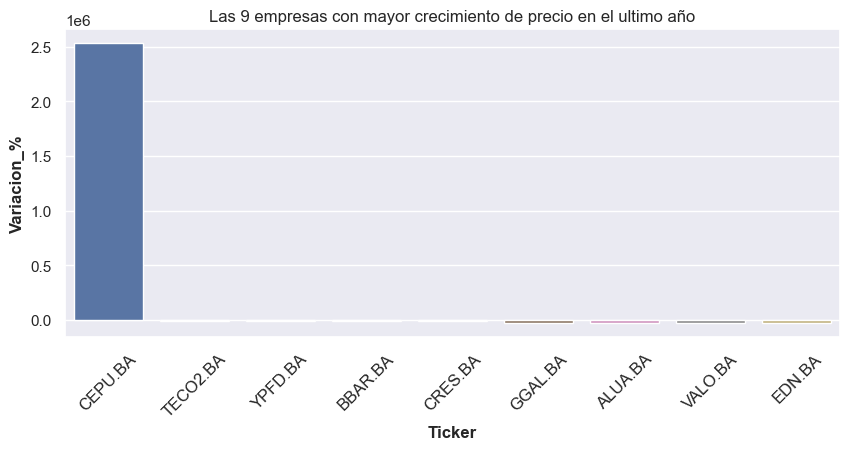

In [59]:
#grafico de barras con las empresas que tienen la mayor variacion de precio en el ultimo año
sns.set(rc={'figure.figsize':(10,4)})
plt.xticks(fontsize=12,rotation=45)
sns.barplot(data = df_anual_var, x='Ticker', y='Variacion_%').set(title="Las 9 empresas con mayor crecimiento de precio en el ultimo año")
plt.show()